# Tri-Mouse Dataset Example
The Tri-Mouse dataset is related to Lauer et al. 2022 (Nature Methods) under CC BY-NC 4.0.

Train dataset: [https://zenodo.org/records/5851157](https://zenodo.org/records/5851157)

Test dataset: [https://zenodo.org/records/8437103](https://zenodo.org/records/8437103)

## Preparation
1. Download and extract the training dataset.

In [1]:
%%bash

# Define variables
TARGET_DIR="dataset/trimice-train/"
ZIP_FILE="trimice-train-dataset.zip"
URL="https://zenodo.org/records/5851157/files/trimice-dlc-2021-06-22.zip?download=1"

# Check if the directory exists
if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    # Download the file
    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    # Create parent directories
    mkdir -p "$TARGET_DIR"

    # Unzip the file
    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    # Remove the zip file
    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded train dataset."

dataset/trimice-train/ does not exist. Proceeding to download and extract...
Downloaded trimice-train-dataset.zip.
Extracted files to dataset/trimice-train/.
Removed trimice-train-dataset.zip.
Successfully downloaded train dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.3M  100 23.3M    0     0  6921k      0  0:00:03  0:00:03 --:--:-- 6922k


2. Similarly, download and extract test dataset.

In [2]:
%%bash

TARGET_DIR="dataset/trimice-test/"
ZIP_FILE="trimice-test-dataset.zip"
URL="https://zenodo.org/records/8437103/files/trimice-dlc-2021-06-22.zip?download=1"

if [ ! -d "$TARGET_DIR" ]; then
    echo "$TARGET_DIR does not exist. Proceeding to download and extract..."

    curl -o $ZIP_FILE "$URL"
    echo "Downloaded $ZIP_FILE."

    mkdir -p "$TARGET_DIR"

    unzip -q $ZIP_FILE -d $TARGET_DIR
    echo "Extracted files to $TARGET_DIR."

    rm $ZIP_FILE
    echo "Removed $ZIP_FILE."
else
    echo "$TARGET_DIR already exists. Skipping download and extraction."
fi

echo "Successfully downloaded test dataset."

dataset/trimice-test/ does not exist. Proceeding to download and extract...
Downloaded trimice-test-dataset.zip.
Extracted files to dataset/trimice-test/.
Removed trimice-test-dataset.zip.
Successfully downloaded test dataset.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  4711k      0  0:00:02  0:00:02 --:--:-- 4710k


3. Download dependecies

In [3]:
%pip install --upgrade ultralytics deeplabcut2yolo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 23.2 MB/s eta 0:00:00


## Convert DeepLabCut (DLC) to YOLO

1. Setup the arguments for d2y.

In [4]:
import deeplabcut2yolo as d2y
from pathlib import Path

dataset_path = Path("dataset/trimice-train/trimice-dlc-2021-06-22")  # Dataset directory to convert using d2y
# Note that the test dataset has no label and does not need to be converted

# List of directories (the image folders) for validation and training.
val_paths = list(dataset_path.glob("labeled-data/*short/"))
train_paths = [item for item in dataset_path.glob("labeled-data/*/") if item not in val_paths and item.suffix != ".cache"]  # Directories that don't contain the word "short"

# The skeleton from the trimouse dataset is ["snout", "leftear", "rightear", "shoulder", "spine1", "spine2", "spine3", "spine4", "tailbase", "tail1", "tail2", "tailend"].
# The only parts that are symmetric are the leftear (index 1) and the rightear (index 2)
skeleton_symmetric_pairs=[(1, 2)]

2. Run the conversion.

In [5]:
d2y.convert(
    dataset_path=dataset_path,
    train_paths=train_paths,
    val_paths=val_paths,
    skeleton_symmetric_pairs=skeleton_symmetric_pairs,
    data_yml_path="data.yml",
    verbose=True,
)

DeepLabCut2YOLO

Dataset path: dataset/trimice-train/trimice-dlc-2021-06-22
Found pickled labels: dataset/trimice-train/trimice-dlc-2021-06-22/training-datasets/iteration-0/UnaugmentedDataSet_trimiceJun22/trimice_dlc70shuffle1.pickle
Found config file: dataset/trimice-train/trimice-dlc-2021-06-22/config.yaml
  nc: 3
  names: {0: 'mus1', 1: 'mus2', 2: 'mus3'}
  kpt: ['snout', 'leftear', 'rightear', 'shoulder', 'spine1', 'spine2', 'spine3', 'spine4', 'tailbase', 'tail1', 'tail2', 'tailend']
  kpt_shape: [12, 3]
Generating data.yml...
Created data.yml: data.yml
  path: /content
  train: ['dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed20', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed4', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed1', 'dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed3', 'dataset/trimice-

100%|██████████| 112/112 [00:00<00:00, 3154.33it/s]


Conversion completed!


## YOLO Transfer Learning

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n-pose.pt").load('yolov8n-pose.pt')
model.train(data="data.yml", epochs=20, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.52M/6.52M [00:00<00:00, 104MB/s]


Transferred 397/397 items from pretrained weights
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=data.yml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8n-pose.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

100%|██████████| 755k/755k [00:00<00:00, 22.2MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[12, 3]
Overriding model.yaml nc=1 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.2MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0... 62 images, 0 backgrounds, 0 corrupt: 100%|██████████| 62/62 [00:00<00:00, 760.42it/s]

train: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed0.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 709.69it/s]

val: New cache created: /content/dataset/trimice-train/trimice-dlc-2021-06-22/labeled-data/videocompressed06short.cache


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.32G      2.719      10.77     0.7221      3.882      2.432         75        640: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

                   all         50        150     0.0151     0.0133    0.00668     0.0015          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.27G      2.761       10.9     0.7205      3.902      2.476         81        640: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         50        150     0.0325     0.0133      0.021    0.00526          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.27G      2.436      10.78      0.718       3.58      2.151         76        640: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         50        150     0.0925      0.287      0.165     0.0543          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.26G      1.938      10.64     0.7052      2.933      1.648         75        640: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         50        150      0.225      0.547      0.222      0.117          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.27G      1.733       10.4     0.6968      2.642       1.44         79        640: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         50        150      0.262      0.542      0.323      0.189          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.28G      1.674      10.38     0.6937      2.478      1.374         91        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


                   all         50        150      0.283      0.495      0.397      0.243          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.27G      1.531      10.04     0.6922      2.347      1.322         96        640: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         50        150      0.352      0.547      0.438      0.242          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.27G      1.462      9.847     0.6901      2.205      1.264         78        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         50        150      0.333      0.347      0.422      0.231          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.28G      1.433      9.794     0.6893      2.104      1.254         92        640: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         50        150      0.218       0.52      0.416      0.247          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.28G      1.291      9.371     0.6835      2.042      1.188         66        640: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         50        150      0.249      0.709      0.368      0.221          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.26G      1.219      9.194     0.6661      2.194       1.13         41        640: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


                   all         50        150      0.249       0.52      0.289      0.174          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.26G      1.231      9.026      0.669      2.138      1.144         41        640: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         50        150      0.329      0.453      0.313      0.181          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.26G      1.143      8.718     0.6574      2.004      1.103         40        640: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         50        150      0.267       0.62      0.344      0.214          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.26G      1.142      8.788     0.6538       2.01       1.09         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         50        150      0.265      0.737       0.38      0.248          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.25G      1.117      8.675     0.6502      1.954      1.051         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         50        150      0.294      0.827      0.366      0.249     0.0161       0.02    0.00169   0.000169



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.25G      1.037      8.448     0.6525      1.883      1.032         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         50        150      0.304      0.882      0.367       0.25     0.0563       0.06     0.0118    0.00118



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.26G      1.062      8.283     0.6414      1.877      1.036         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50        150      0.306       0.82       0.36      0.247     0.0507     0.0533     0.0096    0.00096



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.25G     0.9788      8.133     0.6435      1.842       1.02         42        640: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         50        150      0.309      0.813      0.364      0.248      0.013     0.0133   0.000574   5.74e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.25G     0.9718       8.18     0.6446      1.832      1.008         41        640: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         50        150      0.304       0.81      0.372      0.255     0.0104     0.0133   0.000597   5.97e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.26G     0.9763      8.129     0.6304      1.843     0.9814         42        640: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         50        150      0.309      0.866      0.375      0.258    0.00621    0.00667   0.000138   1.38e-05



20 epochs completed in 0.019 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.6MB

Validating runs/pose/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,190,589 parameters, 0 gradients, 8.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


                   all         50        150      0.308      0.867      0.376      0.259    0.00619    0.00667   0.000136   1.36e-05
                  mus1         50         50      0.308       0.82      0.329      0.211     0.0186       0.02   0.000409   4.09e-05
                  mus2         50         50      0.283       0.78      0.293      0.184          0          0          0          0
                  mus3         50         50      0.333          1      0.504      0.381          0          0          0          0
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/pose/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x793f447c4850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

First, verify that d2y correctly converted the labels and keypoints.

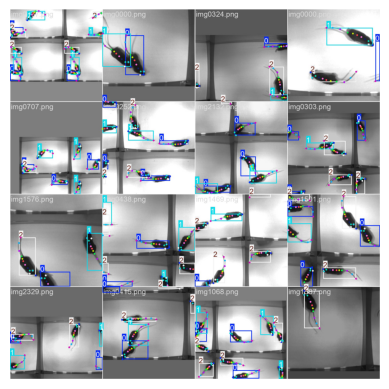

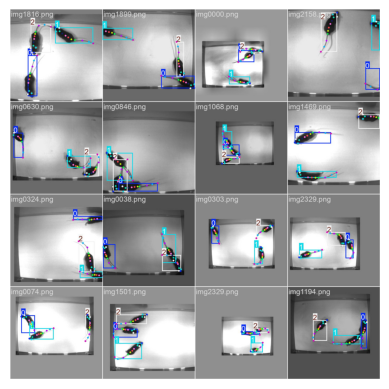

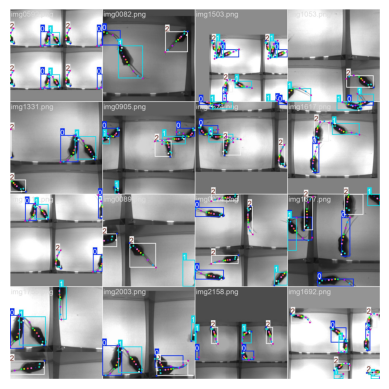

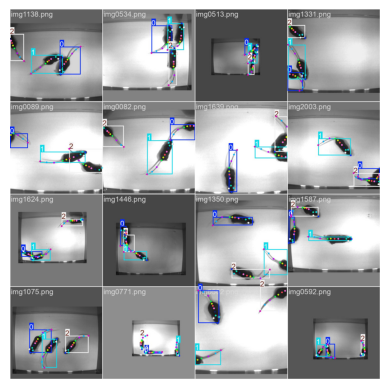

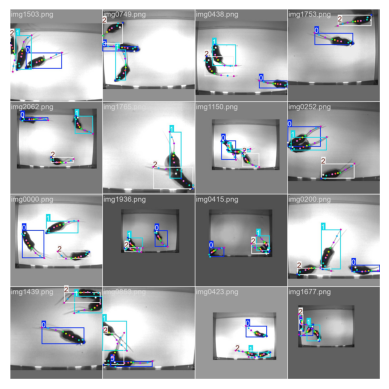

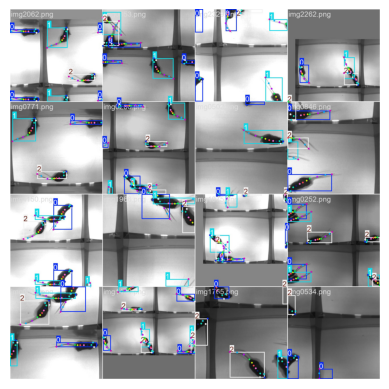

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

for path in Path("/content/runs/pose/train/").glob("train_batch*.jpg"):
  image = Image.open(path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

Here are the validation results from the transfer learning.

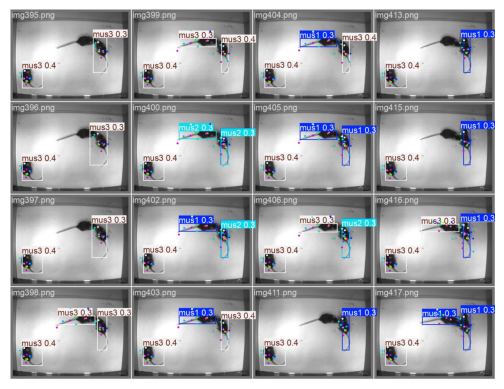

In [11]:
image = Image.open(Path("/content/runs/pose/train/val_batch1_pred.jpg"))
plt.imshow(image)
plt.axis('off')
plt.show()

## Test the Model

In [8]:
image_paths=list(Path("/content/dataset/trimice-test/trimice-dlc-2021-06-22/labeled-data/videocompressed0").glob("*"))
results = model(image_paths)


0: 480x640 2 mus1s, 3 mus2s, 6.2ms
1: 480x640 1 mus1, 1 mus2, 1 mus3, 6.2ms
2: 480x640 1 mus1, 3 mus2s, 1 mus3, 6.2ms
3: 480x640 2 mus1s, 1 mus2, 1 mus3, 6.2ms
4: 480x640 2 mus1s, 3 mus2s, 2 mus3s, 6.2ms
5: 480x640 3 mus1s, 2 mus2s, 6.2ms
6: 480x640 1 mus1, 2 mus2s, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


You can see that the results are not very satisfactory. This is due to small training data.

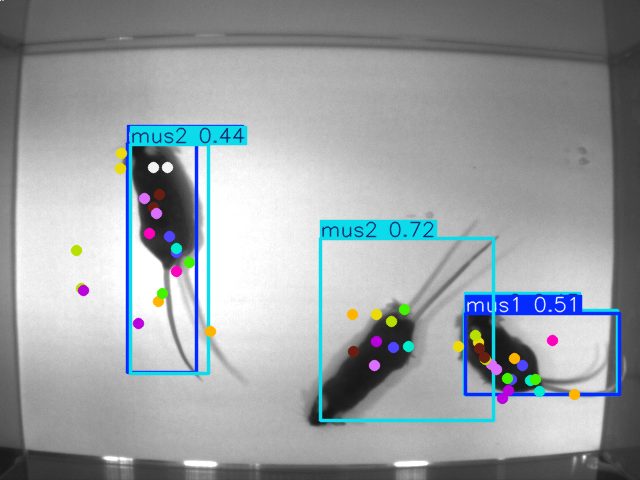

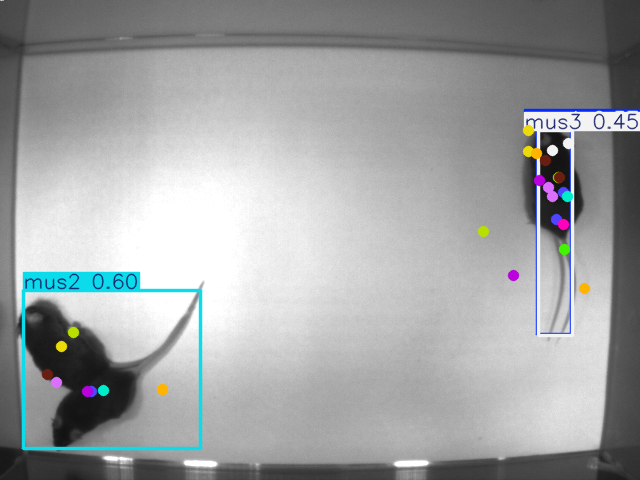

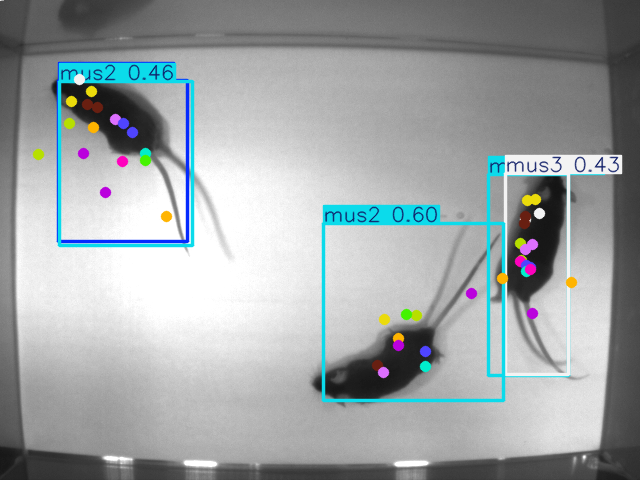

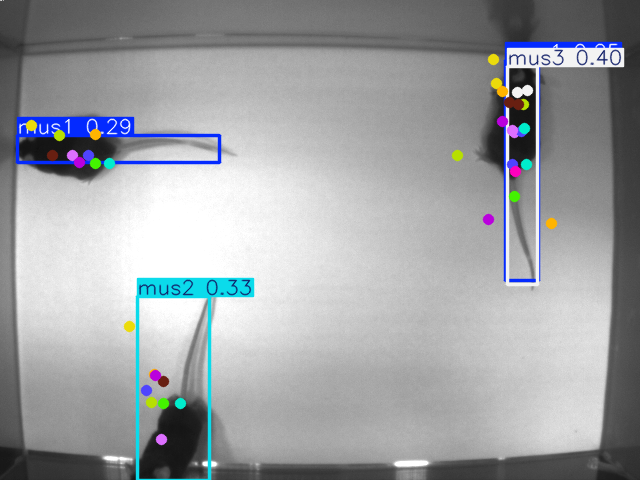

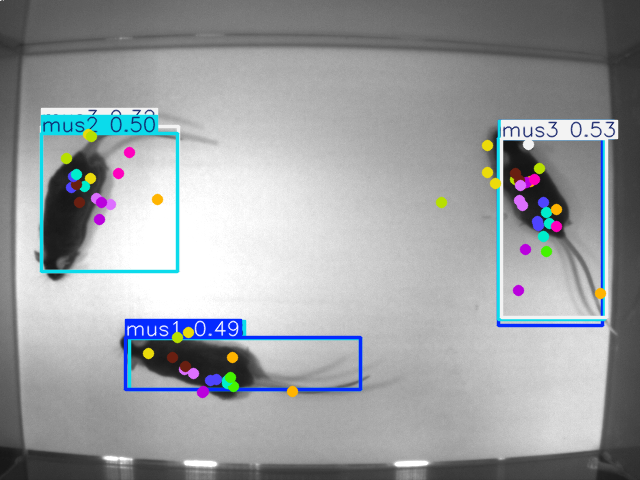

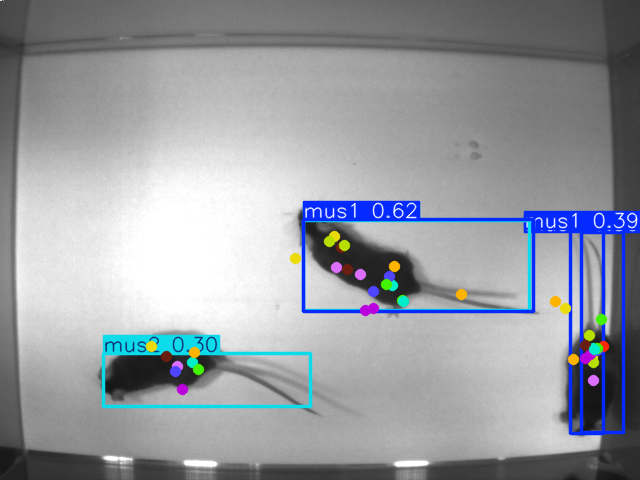

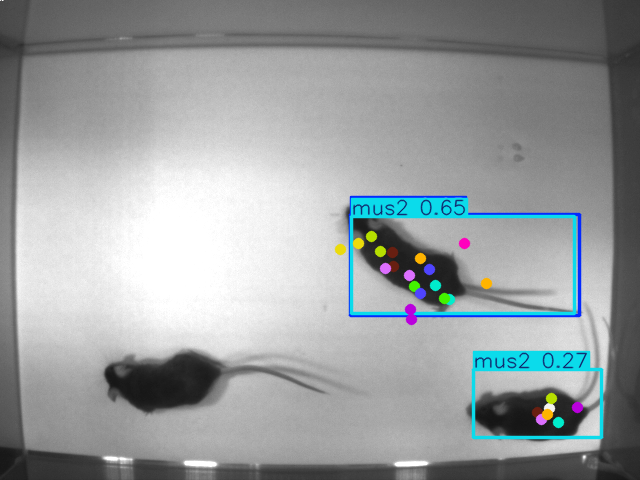

In [9]:
for r in results:
  r.show()